# Seam Carving for Image Resizing
#### Kun Chen 3144546

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## 0. Functions 
Below are three functions for
- energy calculation
- energy accumulation & single seam extration
- multiple seam extration

In [2]:
# energy function for grey scale image
def energy(img, method='grad'):
    if method == 'grad':
        x_grad = np.hstack([img[:,1:], img[:,-1:]]) - np.hstack([img[:,:1], img[:,:-1]])
        y_grad = np.vstack([img[1:,:], img[-1:,:]]) - np.vstack([img[:1,:], img[:-1,:]])
    if method == 'sobel':
        x_grad = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
        y_grad = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
    energy = np.abs(x_grad/2) + np.abs(y_grad/2)
    return energy

In [3]:
# energy accumulation and single seam extration
def get_one_seam(energy):
    h, w = energy.shape
    pos = np.zeros([h,w])
    agg_energy = energy.copy()  # store the sum of all possible energy paths
    energy = np.hstack([energy[:,:1], energy, energy[:,-1:]])   # duplicate the first and the last column for easier selection 
    
    for i in range(1,h):        # from the second row of agg_energy
        for j in range(w):      # from the first item of the row
            neighbor = energy[i-1, j:j+3]
            min_val, min_id = min((val, idx) for (idx, val) in enumerate(neighbor))
            agg_energy[i,j] = agg_energy[i,j] + min_val
            if (min_id==0) & (j==0):     # situation if the pixel on the left edge chooses its upper left neighbor
                pos[i,j] = 0
            elif (min_id==2) & (j==w-1): # situation if the pixel on the right edge chooses its upper right neighbor
                pos[i,j] = 0
            else:
                pos[i,j] = min_id - 1    # convert position 0, 1, 2 into -1, 0, 1
    
    # extract the path of the min seam 
    min_val, min_id = min((val, idx) for (idx, val) in enumerate(agg_energy[-1,:]))
    path = np.ones(h) * min_id
    for i in range(1,h):
        path[i] = path[i-1] + pos[h-i, int(path[i-1])]  # a pixel is identified by the position of its neighbor in the  
                                                        # ... previously processed row plus the relative position (-1, 0, 1) 
                                                        # ... pointed by this neighbor
    path = path[::-1]
    return {'min':min_val, 'path':path}


In [4]:
# extract multiple seams 
def get_final_image(imgcolor, target_width, energy_method='grad'):
    n_rgb = imgcolor.shape[2]
    n_seam = imgcolor.shape[1] - target_width
    imgray = cv.cvtColor(imgcolor,cv.COLOR_RGB2GRAY)
    h = imgray.shape[0]
    
    traj = np.zeros_like(imgray)                        # to keep track of the order of deleted seams
                                                        # 0 means without removal, (n_seam-k+1) means k-th deleted seam
    # after deleting each seam, reconstruct its energy matrix and reset the mask 
    for i in range(n_seam):                
        e = energy(imgray, method=energy_method)
        p = get_one_seam(e)['path']
        mask = np.ones_like(e, bool)                    # to record the pixels to be deleted
        
        # from the top row to the bottom row, mark the deleted pixel in mask and update the trajectory 
        for j in range(h):                 
            loc = int(p[j])                
            mask[j,loc] = False                         
            l = np.where(traj[j,:] == False)            # the index of remaining pixels 
            traj[j, int(l[0][loc])] = int(n_seam - i)   # 'loc' is wrt the resized image, 'l[0][loc]' is wrt the original image 
        imgray = imgray[mask].reshape((h,-1))           
        mask_col = np.repeat(mask[:,:,None], n_rgb, axis=2) # a high dimension of 'mask' to delete seams in the colored image
        imgcolor = imgcolor[mask_col].reshape((h,-1,n_rgb)) 
    return imgcolor, traj
    

---------------------
## 1. Implementation
By changing the image name, energy method and percentage of the axis to keep, below are some visualizations comparing
- the original image
- energy of the gray-scaled image 
- seams detected
- the order of removing seams

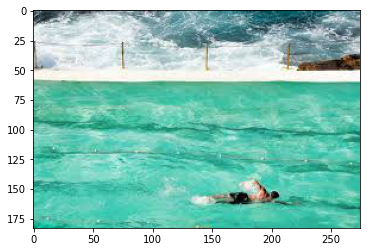

In [5]:
img = plt.imread('swim.jpeg')   # image name here
plt.imshow(img)

In [6]:
method = 'sobel'                # method of energy here
imgray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
e = energy(imgray, method)
percent = 0.7                   # percentage to keep
width = int(percent*img.shape[1])
result, traj= get_final_image(img, width, method)

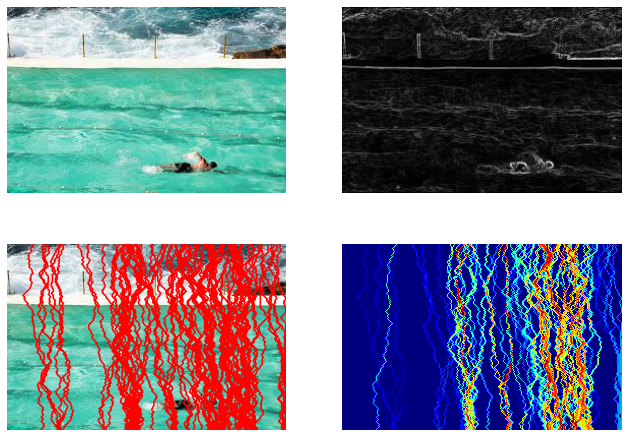

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(11,8))   
ax[0,0].axis('off'), ax[0,1].axis('off'), ax[1,0].axis('off'), ax[1,1].axis('off')
ax[0,0].imshow(img)              # original image

ax[0,1].imshow(e, cmap='gray')   # energy of the image in gray scale

x = np.arange(0,img.shape[0],1)  # original image with all the seams
n_seam = img.shape[1] - width
ax[1,0].imshow(img)  
for i in range(1,n_seam):
    p = np.where(traj==i)[1]
    ax[1,0].plot(p, x, color='red')

ax[1,1].imshow(traj, cmap='jet') # seams with different removing order, red-earlier, blue-later

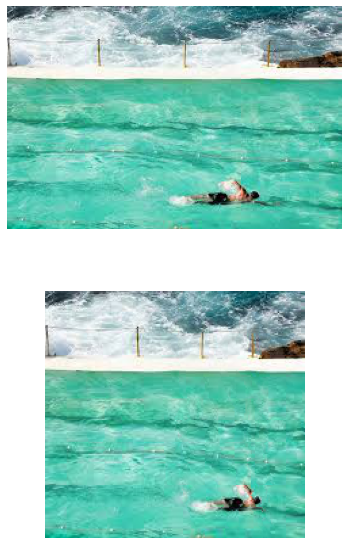

In [8]:
# a comparison between original image and resized image
fig, ax = plt.subplots(2,1, figsize=(6,10))
ax[0].axis('off'), ax[1].axis('off')
ax[0].imshow(img)
ax[1].imshow(result)